### Welcome to the Aryl Chloro/Tosyl (ArClOTs) Selectivity Analysis Project
#### Purpose
The intent of this notebook is two-fold:
1. Investigate the reactivity of various phosphine ligands in a selected reaction to determine an ideal candidate for selective reactions.
2. Serve as an example of machine learning in small-molecule organic chemistry.

#### Running this Code
Via _Binder_ you can execute this entire script in your browser with no manual setup required, just some waiting while things are downloaded in the background. After this initial setup, you can scroll through the entire script, see how things work, and play around with different values to see how things change.

#### Documentation
There is a lot of explanation included around all of the code below to help you work through things line for line, with the idea being that you should be left with questions that you can Google and not anything more foudnational.

### To-Do List
 - add section for fingerprinting with ccbmlib, which does not guarantee uniform-length outputs and will therefore necessitate zero padding. 
 - switch descriptor calculation to PADEL-Py.

##### Step 1: Loading Libraries
All machine learnings algorithms and chemistry tools that we need have (thankfully) already been written by other people, so all we need to do is install them to our notebook here and them use them freely. Here are some brief explanations of what each of these libraries is for:
 - matplotlib: makes plots
 - pandas: interfacing with excel workbooks
 - numpy: adds more datatypes to python, which need in order to store our data
 - sklearn: has all of the machine learning algorithms
 - rdkit: the infamous cheminformatics software package for loading SMILES strings into various computer-readable formats
 - openpyxl: reading and writing excel files
 - ccmblib: handy interface to RDKit to make fingerprint generation easier

In [1]:
%%capture
# the above line just prevents you from getting hundreds of lines of output from the downloaders
!conda install --yes -c rdkit rdkit
!pip install matplotlib pandas numpy sklearn openpyxl
!pip install git+https://github.com/vogt-m/ccbmlib
!conda install -y boost-cpp boost py-boost

##### Step 2: Getting our Data out of Excel
Right now, we have an excel sheet with two important columns: SMILES strings for the ligands, and the Cl:OTs selectivity. In order to get this data into Python, we use pandas like this:

In [2]:
import pandas
data = pandas.read_excel("data/original_paper_data.xlsx", engine='openpyxl')
data

,idx,ligand_name,ligand_smiles,cl_to_ots_selectivity
0,1,PPh3,P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,99.000000
1,2,P(p-OMePh)3,COC(C=C1)=CC=C1P(C2=CC=C(OC)C=C2)C3=CC=C(OC)C=C3,99.000000
2,3,P(p-FPh)3,FC(C=C1)=CC=C1P(C2=CC=C(F)C=C2)C3=CC=C(F)C=C3,99.000000
3,4,PPhMe2,CP(C)C1=CC=CC=C1,0.175439
4,5,PPhEt2,CCP(C1=CC=CC=C1)CC,2.200000
5,6,PPh2Me,CCP(C1=CC=CC=C1)C2=CC=CC=C2,1.000000
6,7,PCy3,P(C1CCCCC1)(C2CCCCC2)C3CCCCC3,1.500000
7,8,P(n-Bu)3,CCCCP(CCCC)CCCC,1.100000
8,9,P(i-bu)3,CC(C)CP(CC(C)C)CC(C)C,2.900000
9,10,Bis(dicyclohexylphosphino)ferrocene,C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.C1=CC=...,99.000000


Now let's get the SMILES strings into a list, as well as the selectivity values.

In [3]:
smiles = data["ligand_smiles"].to_numpy()
smiles

array(['P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3',
       'COC(C=C1)=CC=C1P(C2=CC=C(OC)C=C2)C3=CC=C(OC)C=C3',
       'FC(C=C1)=CC=C1P(C2=CC=C(F)C=C2)C3=CC=C(F)C=C3',
       'CP(C)C1=CC=CC=C1', 'CCP(C1=CC=CC=C1)CC',
       'CCP(C1=CC=CC=C1)C2=CC=CC=C2', 'P(C1CCCCC1)(C2CCCCC2)C3CCCCC3',
       'CCCCP(CCCC)CCCC', 'CC(C)CP(CC(C)C)CC(C)C',
       'C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.[Fe+2]',
       'CCP(CC)CC', 'CP(C)C'], dtype=object)

In [4]:
selectivity = data["cl_to_ots_selectivity"].to_numpy()
selectivity

array([99.        , 99.        , 99.        ,  0.1754386 ,  2.2       ,
        1.        ,  1.5       ,  1.1       ,  2.9       , 99.        ,
        1.8       ,  0.15873016])

##### Step 3: Change the SMILES Strings into Descriptors
Your computer needs to have some representation of the molecules in order to draw conclusions about the reactivity; for this, we use rdkit. This package allows us to generate digital representations of the molecules using fingerprints. To do so, we follow this general procedure:
1. import the functions from rdkit that we need to use
2. Make two empty lists to store our molecules and ginerprints.
3. for each of the SMILES strings, generate a molecule
4. for each of the molecules, generate a molecular fingerprint

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np

molecules = []
fingerprints = []

for smile in smiles:
    molecules.append(Chem.MolFromSmiles(smile))

for molecule in molecules:
    # start by generating the fingerprint as a bit vector, which is a list of 1's and 0's
    temp_fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, 2)
    
    # in order to use this later, we need to convert it into an array. to begin, make an empty array
    temp_array = np.array((0,), dtype=np.int8)
    
    # put the fingerprint into the array
    DataStructs.ConvertToNumpyArray(temp_fingerprint, temp_array)
    
    # save this temporary array into the fingerprint array
    fingerprints.append(temp_array)

Take a look at the cell below, which shows what the fingerprints array _actually looks like_. It is a list, and every component of the list is itself a list of 1's and 0's. Each of those sub-lists represents one of the molecules in our dataset, and the computer can interpret the 1's and 0's, as well as their relative placement to one another, as a molecule.

In [6]:
fingerprints

[array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 1, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 1, 0, 0], dtype=int8),
 array([0, 1, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8)]

##### Step 4: Establishing a Baseline
To 'train' our model, we are going to use cross-validation. First, this splits the data into a grop of 75% and 25%, lets the model look at the 75% of the data, and then asks it to predict the remaining 25%. Then, it repeats this process but changes around which ligands in the 75% (training data) and which are in the 25% (testing data). This is repeated until all of the samples have been in _both_ the training data and the testing data, which gives us a much better idea of how our model is performing. Graphically, it looks like this:
<div>
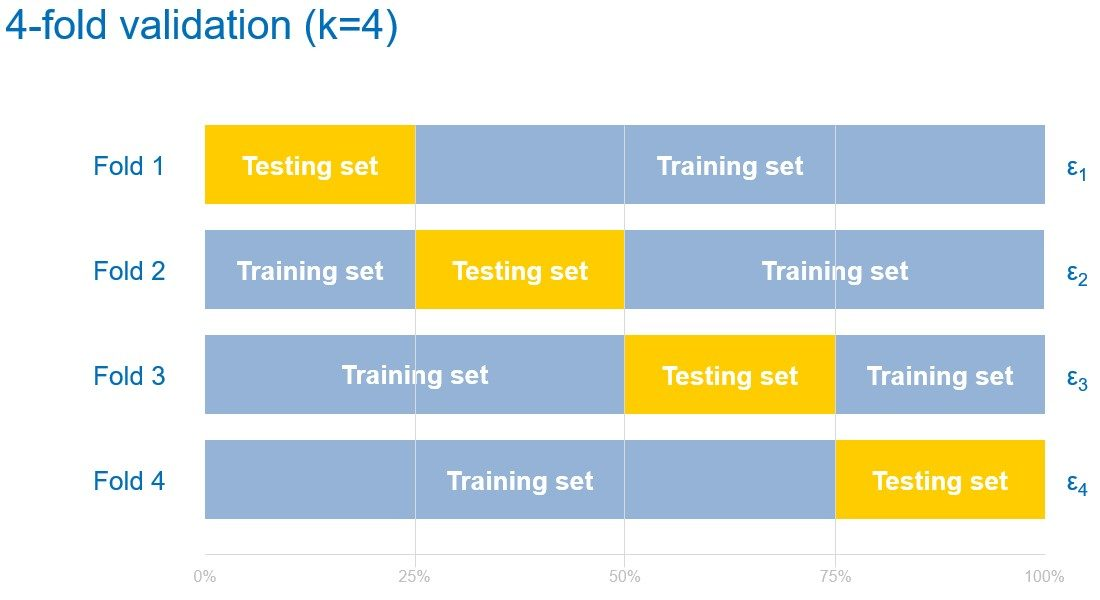
</div>

In [7]:
from sklearn.model_selection import KFold
# make our groups
groups = KFold(n_splits=4)

In order to determine if our 'real' models are actually _learning_ anything, we need have a baseline model to which we can make comparisons. There are multiple types of baseline models, and we will explore one here: Guessing the Mean

This approach to determining the selectivity based on the ligand would be to just guess the mean selectivity from the input list every time you are a given a ligand. Sklearn (the library we use to do machine learning in Python) considers this a "dummy" model.

In [9]:
from sklearn.dummy import DummyRegressor
# setup our mean guessing model
mean_model = DummyRegressor(strategy="mean")

from sklearn.model_selection import cross_val_predict, cross_val_score
mean_score_r2 = cross_val_score(mean_model, fingerprints, selectivity, cv=groups, scoring='r2')
mean_score_MAE = cross_val_score(mean_model, fingerprints, selectivity, cv=groups, scoring='neg_mean_absolute_error')
print(f"Average R2: {mean_score_r2.mean():.2f} +/- {mean_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*mean_score_MAE.mean():.2f} +/- {mean_score_MAE.std():.2f}")

Average R2: -1458.56 +/- 1462.56
Average Mean Absolute Error: 54.23 +/- 18.80


This is totally _dismal_ performance. The R^2 values are laughably terrible to the point of being meaningless. The mean absolute error is actually telling us something. MAE is essentially saying "on average, how far off was each prediction?" For us, guessing the mean every time usually gave us an error of about 54 'selectivity'. Our dataset only included example from 99 to 0.15, so this really is quite bad.

Let's plot the results and figure out why it did so poorly. The plot we are making in the code below is called a 'Prediction Error Plot'.

In [11]:
mean_predictions = cross_val_predict(mean_model, fingerprints, selectivity, cv=groups)
mean_predictions

array([12.20379653, 12.20379653, 12.20379653, 44.8287478 , 44.8287478 ,
       44.8287478 , 44.59268542, 44.59268542, 44.59268542, 33.98615984,
       33.98615984, 33.98615984])

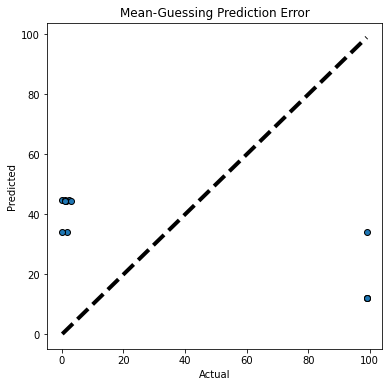

In [12]:
from helper_functions import prediction_error_plot

prediction_error_plot(selectivity, mean_predictions, title='Mean-Guessing Prediction Error')

##### Step 5: Training our First Model
Now that we have an idea of the worst case performance, let's start training some acutal models to see if they can learn anything. The first one we will try will use the molecular fingerprints which we generated earlier as the input, and the type of model we train is called a Random Forest Regressor. Read about this more on [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).
This code is copy-pasted from above, with just some minor changes to which model it uses. If we wanted to, we could put all of this into it's own separate function, but that would get really confusing really fast, so we will stick with this.

In [14]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(criterion="mae")

random_forest_score_r2 = cross_val_score(
    random_forest_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='r2',
)
random_forest_score_MAE = cross_val_score(
    random_forest_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)
print(f"Average R2: {random_forest_score_r2.mean():.2f} +/- {random_forest_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*random_forest_score_MAE.mean():.2f} +/- {random_forest_score_MAE.std():.2f}")

Average R2: -2688.37 +/- 3915.47
Average Mean Absolute Error: 59.43 +/- 29.96


Still looks terrible, but let's look at the plot.

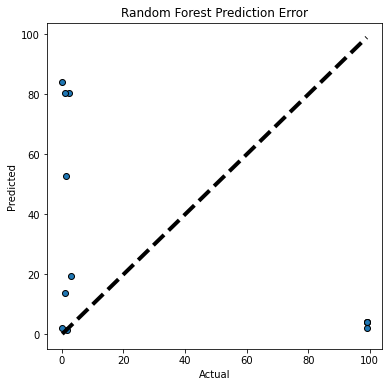

In [15]:
random_forest_predictions = cross_val_predict(random_forest_model, fingerprints, selectivity, cv=groups)
prediction_error_plot(selectivity, random_forest_predictions, title='Random Forest Prediction Error')

While the error metrics look worse on this one, the plot tells a slightly different story. Most of the time the Random Forest model is just as bad as random guessing, but in one case it is able to guess with accuracy! Let's try another model, this time the Nearest-Neighbors ([Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)), to see if it makes a difference.

Average R2: -1094.07 +/- 1289.20
Average Mean Absolute Error: 47.23 +/- 26.77


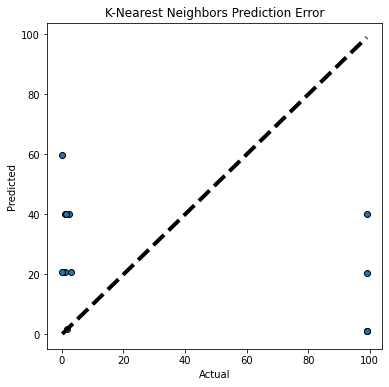

In [16]:
from sklearn.neighbors import KNeighborsRegressor
neighbors_model = KNeighborsRegressor()

neighbors_score_r2 = cross_val_score(
    neighbors_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='r2',
)
neighbors_score_MAE = cross_val_score(
    neighbors_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)
print(f"Average R2: {neighbors_score_r2.mean():.2f} +/- {neighbors_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*neighbors_score_MAE.mean():.2f} +/- {neighbors_score_MAE.std():.2f}")

random_forest_predictions = cross_val_predict(neighbors_model, fingerprints, selectivity, cv=groups)
prediction_error_plot(selectivity, random_forest_predictions, title='K-Nearest Neighbors Prediction Error')

This result is interesting -- none of the points are correct, but the overall error is lower. While Random Forest was able to predict some of the ligands correctly, K-Nearest Neighbors was able to get a bit closer on all of them.

Just for completeness sake, let's train a Linear Regression and see how it does.

Average R2: -1636.70 +/- 2517.28
Average Mean Absolute Error: 46.14 +/- 29.13


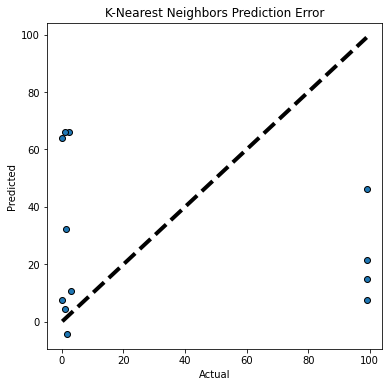

In [18]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

linear_score_r2 = cross_val_score(
    linear_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='r2',
)
linear_score_MAE = cross_val_score(
    linear_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)
print(f"Average R2: {linear_score_r2.mean():.2f} +/- {linear_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*linear_score_MAE.mean():.2f} +/- {linear_score_MAE.std():.2f}")

linear_predictions = cross_val_predict(linear_model, fingerprints, selectivity, cv=groups)
prediction_error_plot(selectivity, linear_predictions, title='K-Nearest Neighbors Prediction Error')

Surprise, surprise! Simple linear regression is actually able to decrease the overall error _and_ get some of the ligands correct. Linear regression is actually a reasonable approach to take here, given how few data points we have. 